# Evo 2 Mech Interp Example Notebook
### 25.06.05

Minimal example of extracting features for an *E. coli* genome chunk and plotting to recreate parts of the main and supplementary figures

In [1]:
!pip install matplotlib

In [2]:
from typing import List, Optional, Callable

import torch

from Bio import SeqIO

import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download

from tqdm.notebook import tqdm

from evo2 import Evo2


# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.set_grad_enabled(False)

/large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[09/15/25 10:28:42] WARNING  transformer_engine.pytorch.attention.dot_product_attention.utils -      ]8;id=707555;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/transformer_engine/pytorch/attention/dot_product_attention/backends.py\backends.py]8;;\:]8;id=58520;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/transformer_engine/pytorch/attention/dot_product_attention/backends.py#98\98]8;;\
                             WARNING - Supported flash-attn versions are >= 2.1.1, <= 2.7.4.post1.                 
                             Found flash-attn 2.8.0.post2.                                                         

## Load SAE

In [3]:
class ModelScope:
    """Class for adding, using, and removing PyTorch hooks with a model."""

    def __init__(self, model):
        self.model = model
        self.hooks = {}
        self.activations_cache = {}
        self.override_store = {}
        self._build_module_dict()

    """Module listing."""
    def _build_module_dict(self):
        """Walks the model's module tree and builds a name: module map."""
        self._module_dict = {}

        def recurse(module, prefix=''):
            """Recursive tree walk to build self._module_dict."""
            for name, child in module.named_children():
                self._module_dict[prefix+name] = child
                recurse(child, prefix=prefix+name+'-')

        recurse(self.model)  # build the tree

    def list_modules(self):
        """Lists all modules in the module dictionary."""
        return self._module_dict.keys()
    
    """Generic hook registration"""
    def add_hook(self, hook_fn, module_str, hook_name):
        """Add a hook_fn to the module given by module_str."""
        module = self._module_dict[module_str]
        hook_handle = module.register_forward_hook(hook_fn)
        self.hooks[hook_name] = hook_handle
    
    """Activations caching"""
    def _build_caching_hook(self, module_str):
        self.activations_cache[module_str] = []
        def hook_fn(model, input, output):
            self.activations_cache[module_str].append(output)

        return hook_fn

    def add_caching_hook(self, module_str):
        """Adds an activations caching hook at the location in module_str."""
        hook_fn = self._build_caching_hook(module_str)
        self.add_hook(hook_fn, module_str, 'cache-'+module_str)

    def clear_cache(self, module_str):
        """Clears the activations cache corresponding to module_str."""
        if module_str not in self.activations_cache.keys():
            raise KeyError(f'No activations cache for {module_str}.')
        
        else:
            self.activations_cache[module_str] = []

    def clear_all_caches(self):
        """Clear all activation caches."""
        for module_str in self.activations_cache.keys():
            self.clear_cache(module_str)

    def remove_cache(self, module_str):
        """Remove the cache for module_str."""
        del self.activations_cache[module_str]

    def remove_all_caches(self):
        """Remove all caches."""
        caches = list(self.activations_cache.keys())
        for cache_str in caches:
            self.remove_cache(cache_str)

    """Activation override"""
    def _build_override_hook(self, module_str):
        self.override_store[module_str] = None  # won't override when returned
        def hook_fn(model, input, output):
            return self.override_store[module_str]
        
        return hook_fn
    
    def add_override_hook(self, module_str):
        """Adds hook to overrides output of module_str using override_store"""
        hook_fn = self._build_override_hook(module_str)
        self.add_hook(hook_fn, module_str, 'override-'+module_str)

    def override(self, module_str, override_tensor):
        """Sets the override tensor for module_str."""
        self.override_store[module_str] = override_tensor

    def clear_override(self, module_str):
        """Clear override hook so it won't affect forward pass."""
        self.override_store[module_str] = None

    def clear_all_overrides(self):
        """Clear all override hooks."""
        overrides = list(self.override_store.keys())
        for override in overrides:
            self.clear_override(override)

    """Hook clearup"""
    def remove_hook(self, hook_name):
        """Remove a hook with name hook_name from the model."""
        self.hooks[hook_name].remove()
        del self.hooks[hook_name]

    def remove_all_hooks(self):
        """Remove all hooks from the model."""
        hooks = list(self.hooks.keys())
        for hook_name in hooks:
            self.remove_hook(hook_name)


INTERVENTION_INTERFACE = Callable[[torch.Tensor], torch.Tensor]


class ObservableEvo2:
    def __init__(self, model_name: str):
        self.model_name = model_name
        self.evo_model: NucleotideModel = Evo2(model_name)
        self.scope = ModelScope(self.evo_model.model)
        self.tokenizer = self.evo_model.tokenizer
        self.model = self.evo_model.model
        self.d_hidden = 4096

    @property
    def device(self):
        return next(self.evo_model.model.parameters()).device
        
    @property
    def dtype(self):
        return self.evo_model.dtype

    def list_modules(self):
        return self.scope.list_modules()

    def forward(
        self, 
        toks: torch.Tensor, 
        cache_activations_at: Optional[List[str]] = None, 
        interventions: dict[str, INTERVENTION_INTERFACE] = None,
    ):
        if not interventions:
            interventions = {}

        if not cache_activations_at:
            cache_activations_at = []

        output_cache = {}

        layers = list(set(list(interventions.keys()) + cache_activations_at))

        if layers:
            for layer in layers:
                def _intervene(model, input, output):
                    acts = output[0] if isinstance(output, tuple) else output

                    if layer in interventions:
                        acts = interventions[layer](acts)
                    '''
                    if layer in cache_activations_at and output_cache.get(layer, None) is None:
                        output_cache[layer] = [acts]
                    elif layer in cache_activations_at:
                        output_cache[layer].append(acts)
                    '''
                    if layer in cache_activations_at:
                        output_cache[layer] = acts.detach()
                    '''
                    if len(output) == 2:
                        return (acts, output[1])
                    else:
                        return acts
                    '''
                    return (acts, output[1]) if isinstance(output, tuple) else acts
                
                self.scope.add_hook(_intervene, layer, f'intervene-{layer}')

        # Run forwards pass
        try:
            model_outputs = self.model(toks)
            #cache = {key: output[0][0] for key, output in self.scope.activations_cache.items()}
            cached_activations = {layer: act.clone() for layer, act in output_cache.items()}
        finally:
            self.scope.remove_all_hooks()
            self.scope.clear_all_caches()
                                                   
        return model_outputs[0], cached_activations #{layer: act.clone().detach() for layer, act in output_cache.items()}

    def generate(
        self,
        prompt_seqs: List[str],
        n_tokens: int = 100,
        temperature: float = 1.0,
        top_k: int = 4,
        top_p: float = 1.,
        batched: bool = True,
        cached_generation: bool = False,
        verbose: int = 0,
        cache_activations_at: Optional[List[str]] = None, 
        interventions: dict[str, INTERVENTION_INTERFACE] = None,
    ):
        #ACTIVATION_SCALING_CONSTANT = 2.742088556289673
        if not interventions:
            interventions = {}

        if not cache_activations_at:
            cache_activations_at = []

        output_cache = {}

        layers = list(set(list(interventions.keys()) + cache_activations_at))

        if layers:
            for layer in layers:
                def _intervene(model, input, output):
                    acts = output[0]

                    if layer in interventions:
                        acts = interventions[layer](acts) # * ACTIVATION_SCALING_CONSTANT) / ACTIVATION_SCALING_CONSTANT

                    if layer in cache_activations_at and output_cache.get(layer, None) is None:
                        output_cache[layer] = [acts] # * ACTIVATION_SCALING_CONSTANT]
                    elif layer in cache_activations_at:
                        output_cache[layer].append(acts)

                    if len(output) == 2:
                        return (acts, output[1])
                    else: 
                        return acts
                    # return (acts, output[1])
                
                self.scope.add_hook(_intervene, layer, f'intervene-{layer}')

        # Run forwards pass
        try:
            output = self.evo_model.generate(
                prompt_seqs,
                n_tokens=n_tokens,
                temperature=temperature,
                top_k=top_k,
                top_p=top_p,
                batched=batched,
                cached_generation=cached_generation,
                verbose=verbose,
            )
        finally:
            self.scope.remove_all_hooks()
            self.scope.clear_all_caches()

        acts_cache = {layer: torch.cat(acts, dim=1).clone().detach() for layer, acts in output_cache.items()}
                       
        return ''.join(output[0]), acts_cache

class BatchTopKTiedSAE(torch.nn.Module):
    def __init__(
        self,
        d_in,
        d_hidden,
        k,
        device,
        dtype,
        tiebreaker_epsilon: float = 1e-6
        ):
        super().__init__()
        self.d_in = d_in
        self.d_hidden = d_hidden
        self.k = k
        
        W_mat = torch.randn((d_in, d_hidden))
        W_mat = 0.1 * W_mat / torch.linalg.norm(W_mat, dim=0, ord=2, keepdim=True)
        self.W = torch.nn.Parameter(W_mat)
        self.b_enc = torch.nn.Parameter(torch.zeros(self.d_hidden))
        self.b_dec = torch.nn.Parameter(torch.zeros(self.d_in))
        self.device = device
        self.dtype = dtype
        self.tiebreaker_epsilon = tiebreaker_epsilon
        self.tiebreaker = torch.linspace(0, tiebreaker_epsilon, d_hidden)
        self.to(self.device, self.dtype)
        
    def encoder_pre(self, x):
        return x @ self.W + self.b_enc

    def encode(self, x, tiebreak=False):
        f = torch.nn.functional.relu(self.encoder_pre(x))
        return self._batch_topk(f, self.k, tiebreak=tiebreak)
    
    def _batch_topk(self, f, k, tiebreak=False):
        from math import prod

        if tiebreak:  # break ties in feature order for determinism
            f += self.tiebreaker.broadcast_to(f)
        *input_shape, _ = f.shape  # handle higher-dim tensors (e.g. from sequence input)
        numel = k * prod(input_shape)
        f_topk = torch.topk(f.flatten(), numel, dim=-1)
        f_topk = torch.zeros_like(f.flatten()).scatter(-1, f_topk.indices, f_topk.values).reshape(f.shape)
        return f_topk

    def decode(self, f):
        return f @ self.W.T + self.b_dec

    def forward(self, x):
        f = self.encode(x)
        return self.decode(f), f

def load_topk_sae(
    sae_path: str,
    d_hidden: int,
    device: str,
    dtype: torch.dtype,
    expansion_factor: int = 16,
):
    sae_dict = torch.load(sae_path, weights_only=True, map_location="cpu")

    new_dict = {}
    for key, item in sae_dict.items():
        new_dict[key.replace("_orig_mod.", "").replace("module.", "")] = item

    sae_dict = new_dict

    cached_sae = BatchTopKTiedSAE(
        d_hidden,
        d_hidden * expansion_factor,
        64, # this is a topk64 sae
        device,
        dtype,
    )
    cached_sae.load_state_dict(sae_dict)

    return cached_sae

In [4]:
file_path = hf_hub_download(
    repo_id=f"Goodfire/Evo-2-Layer-26-Mixed",
    filename=f"sae-layer26-mixed-expansion_8-k_64.pt",
    repo_type="model"
)
file_path

'/large_storage/hielab/gbrixi/checkpoints/hf_testing/hub/models--Goodfire--Evo-2-Layer-26-Mixed/snapshots/a02b08a876b112d1c5da172e57a59e2bc76b1d70/sae-layer26-mixed-expansion_8-k_64.pt'

In [5]:
model = ObservableEvo2(model_name="evo2_7b_262k")
topk_sae = load_topk_sae(
    file_path,
    d_hidden=model.d_hidden,
    device=model.device,
    dtype=torch.bfloat16,
    expansion_factor=8
)
SAE_LAYER_NAME = 'blocks-26'

Fetching 4 files: 100%|██████████| 4/4 [00:00<00:00, 47798.34it/s]

Found complete file in repo: evo2_7b_262k.pt


[09/15/25 10:28:43] INFO     StripedHyena - INFO - Initializing StripedHyena with config:              ]8;id=425244;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=271331;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#616\616]8;;\
                             {'model_name': 'shc-evo2-7b-8k-2T-v2', 'vocab_size': 512, 'hidden_size':              
                             4096, 'num_filters': 4096, 'hcl_layer_idxs': [2, 6, 9, 13, 16, 20, 23,                
                             27, 30], 'hcm_layer_idxs': [1, 5, 8, 12, 15, 19, 22, 26, 29],                         
                             'hcs_layer_idxs': [0, 4, 7, 11, 14, 18, 21, 25, 28], 'attn_layer_idxs':               
                             [3, 10, 17, 24, 31], 'hcm_filter_length': 128, 'hcl_filter_groups': 4096,             
                             'hcm_filter_groups': 256, 'hcs_filter_groups': 256, 'hcs_filter_length':              
                             7, 'num_layers': 32, 'short_filter_length': 3, 'num_attention_heads': 32,             
                             'short_filter_bias': False, 'mlp_init_method': 'torch.nn.init.zeros_',                
                             'mlp_output_init_method': 'torch.nn.init.zeros_', 'eps': 1e-06,                       
                             'state_size': 16, 'rotary_emb_base': 10000, 'rotary_emb_scaling_factor':              
                             32, 'use_interpolated_rotary_pos_emb': True,                                          
                             'make_vocab_size_divisible_by': 8, 'inner_size_multiple_of': 16,                      
                             'inner_mlp_size': 11008, 'log_intermediate_values': False, 'proj_groups':             
                             1, 'hyena_filter_groups': 1, 'column_split_hyena': False, 'column_split':             
                             True, 'interleave': True, 'evo2_style_activations': True,                             
                             'model_parallel_size': 1, 'pipe_parallel_size': 1, 'tie_embeddings':                  
                             True, 'mha_out_proj_bias': True, 'hyena_out_proj_bias': True,                         
                             'hyena_flip_x1x2': False, 'qkv_proj_bias': False,                                     
                             'use_fp8_input_projections': True, 'max_seqlen': 262144,                              
                             'max_batch_size': 1, 'final_norm': True, 'use_flash_attn': True,                      
                             'use_flash_rmsnorm': False, 'use_flash_depthwise': False, 'use_flashfft':             
                             False, 'use_laughing_hyena': False, 'inference_mode': True,                           
                             'tokenizer_type': 'CharLevelTokenizer', 'prefill_style': 'fft',                       
                             'mlp_activation': 'gelu', 'print_activations': False, 'Loader': <class                
                             'yaml.loader.FullLoader'>}                                                            

                    INFO     StripedHyena - INFO - Initializing 32 blocks...                           ]8;id=808684;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=866373;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#635\635]8;;\

                    INFO     StripedHyena - INFO - Distributing across 1 GPUs, approximately 32 layers ]8;id=281254;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=186449;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#642\642]8;;\
                             per GPU                                                                               

  0%|          | 0/32 [00:00<?, ?it/s]

                    INFO     StripedHyena - INFO - Assigned layer_idx=0 to device='cuda:0'             ]8;id=637230;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=678995;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 0: 202426112              ]8;id=511639;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=585017;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=1 to device='cuda:0'             ]8;id=250195;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=814637;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 1: 202461184              ]8;id=341623;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=561809;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=2 to device='cuda:0'             ]8;id=109772;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=713354;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 2: 202559488              ]8;id=299007;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=321111;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=3 to device='cuda:0'             ]8;id=329486;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=923887;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 3: 202387456              ]8;id=115098;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=677647;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

 12%|█▎        | 4/32 [00:00<00:00, 36.33it/s]

                    INFO     StripedHyena - INFO - Assigned layer_idx=4 to device='cuda:0'             ]8;id=55238;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=672382;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 4: 202426112              ]8;id=617165;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=11760;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=5 to device='cuda:0'             ]8;id=115241;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=234490;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 5: 202461184              ]8;id=722381;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=658766;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=6 to device='cuda:0'             ]8;id=496345;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=971208;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 6: 202559488              ]8;id=229570;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=373408;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=7 to device='cuda:0'             ]8;id=32146;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=764494;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 7: 202426112              ]8;id=524076;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=854605;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=8 to device='cuda:0'             ]8;id=467105;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=749854;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 8: 202461184              ]8;id=343374;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=264355;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=9 to device='cuda:0'             ]8;id=458129;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=920253;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 9: 202559488              ]8;id=546311;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=503410;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=10 to device='cuda:0'            ]8;id=583852;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=378964;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 10: 202387456             ]8;id=164791;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=703024;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=11 to device='cuda:0'            ]8;id=638046;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=214841;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 11: 202426112             ]8;id=870239;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=150330;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=12 to device='cuda:0'            ]8;id=589413;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=750434;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 12: 202461184             ]8;id=861659;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=734737;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=13 to device='cuda:0'            ]8;id=211749;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=23434;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 13: 202559488             ]8;id=358794;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=306777;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=14 to device='cuda:0'            ]8;id=978816;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=401966;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 14: 202426112             ]8;id=971613;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=69805;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=15 to device='cuda:0'            ]8;id=448223;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=984203;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 15: 202461184             ]8;id=299598;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=982649;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=16 to device='cuda:0'            ]8;id=152963;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=402629;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 16: 202559488             ]8;id=616650;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=655126;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=17 to device='cuda:0'            ]8;id=182957;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=406981;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 17: 202387456             ]8;id=379314;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=829290;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=18 to device='cuda:0'            ]8;id=216667;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=707990;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 18: 202426112             ]8;id=425163;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=22435;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=19 to device='cuda:0'            ]8;id=135901;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=794808;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 19: 202461184             ]8;id=910838;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=883524;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=20 to device='cuda:0'            ]8;id=849941;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=347189;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 20: 202559488             ]8;id=249101;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=171356;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=21 to device='cuda:0'            ]8;id=931976;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=530878;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 21: 202426112             ]8;id=666366;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=693739;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=22 to device='cuda:0'            ]8;id=396850;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=786312;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 22: 202461184             ]8;id=839800;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=630338;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=23 to device='cuda:0'            ]8;id=602202;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=857577;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 23: 202559488             ]8;id=284565;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=387628;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=24 to device='cuda:0'            ]8;id=455188;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=780305;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 24: 202387456             ]8;id=77722;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=77588;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=25 to device='cuda:0'            ]8;id=111062;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=714587;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 25: 202426112             ]8;id=90348;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=452798;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

 81%|████████▏ | 26/32 [00:00<00:00, 137.44it/s]

                    INFO     StripedHyena - INFO - Assigned layer_idx=26 to device='cuda:0'            ]8;id=134686;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=211950;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 26: 202461184             ]8;id=541547;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=54486;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=27 to device='cuda:0'            ]8;id=227106;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=837004;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 27: 202559488             ]8;id=998514;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=319442;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=28 to device='cuda:0'            ]8;id=980110;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=646833;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 28: 202426112             ]8;id=152759;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=724762;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=29 to device='cuda:0'            ]8;id=540304;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=901289;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 29: 202461184             ]8;id=63304;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=679605;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=30 to device='cuda:0'            ]8;id=317297;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=165687;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 30: 202559488             ]8;id=162998;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=272678;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=31 to device='cuda:0'            ]8;id=307165;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=54957;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#660\660]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 31: 202387456             ]8;id=149089;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=925530;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#661\661]8;;\

100%|██████████| 32/32 [00:00<00:00, 132.38it/s]


                    INFO     StripedHyena - INFO - Initialized model                                   ]8;id=635788;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=640685;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#680\680]8;;\

                    INFO     vortex.model.utils - INFO - Loading                                        ]8;id=543477;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/utils.py\utils.py]8;;\:]8;id=160832;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/utils.py#92\92]8;;\
                             /large_storage/hielab/gbrixi/checkpoints/hf_testing/hub/models--arcinstitu            
                             te--evo2_7b_262k/snapshots/27c4f055e8b729a27ab5c3e6c8b9c35367a76fba/evo2_7            
                             b_262k.pt                                                                             

Extra keys in state_dict: {'blocks.24.mixer.dense._extra_state', 'blocks.27.mixer.mixer.filter.t', 'blocks.13.mixer.mixer.filter.t', 'blocks.30.mixer.mixer.filter.t', 'blocks.3.mixer.dense._extra_state', 'blocks.17.mixer.dense._extra_state', 'blocks.23.mixer.mixer.filter.t', 'blocks.16.mixer.mixer.filter.t', 'blocks.2.mixer.mixer.filter.t', 'unembed.weight', 'blocks.6.mixer.mixer.filter.t', 'blocks.9.mixer.mixer.filter.t', 'blocks.20.mixer.mixer.filter.t', 'blocks.10.mixer.dense._extra_state', 'blocks.31.mixer.dense._extra_state'}


[09/15/25 10:28:45] INFO     StripedHyena - INFO - Adjusting Wqkv for column split (permuting rows)    ]8;id=9671;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py\model.py]8;;\:]8;id=991160;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/model.py#964\964]8;;\

## Compute and visualize some features

In [6]:
def get_feature_ts(sae, seq): # Faster, but might crash
    toks = model.tokenizer.tokenize(seq)
    toks = torch.tensor(toks, dtype=torch.long).unsqueeze(0).to(model.device)
    logits, acts = model.forward(toks, cache_activations_at=[SAE_LAYER_NAME])
    feats = sae.encode(acts[SAE_LAYER_NAME][0])
    return feats.cpu().detach().float().numpy()

def get_feature_ts_via_generate(sae, seq): # Slower, but won't crash
    logits, acts = model.generate([seq], n_tokens=1, cached_generation=True, cache_activations_at=[SAE_LAYER_NAME])
    feats = sae.encode(acts[SAE_LAYER_NAME][0])
    return feats.cpu().detach().float().numpy()

In [7]:
# Let's get features for 1 kb of human genome sequence (randomly selected from chr17 GRCh38.p14)
example_seq = 'TCTGAAAGGACAGTTTTATTGTAGGTACACATGGCTGCCATTTCAAATGTAACTCACAGCTTGTCCATCAGTCCTTGGAGGTCTTTCTATGAAAGGAGCTTGGTGGCGTCCAAACACCACCCAATGTCCACTTAGAAGTAAGCACCGTGTCTGCCCTGAGCTGACTCCTTTTCCAAGGAAGGGGTTGGATCGCTGAGTGTTTTTCCAGGTGTCTACTTGTTGTTAATTAATAGCAATGACAAAGCAGAAGGTTCATGCGTAGCTCGGCTTTCTGGTATTTGCTGCCCGTTGACCAATGGAAGATAAACCTTTGCCTCAGGTGGCACCACTAGCTGGTTAAGAGGCACTTTGTCCTTTCACCCAGGAGCAAACGCACATCACCTGTGTCCTCATCTGATGGCCCTGGTGTGGGGCACAGTCGTGTTGGCAGGGAGGGAGGTGGGGTTGGTCCCCTTTGTGGGTTTGTTGCGAGGCCGTGTTCCAGCTGTTTCCACAGGGAGCGATTTTCAGCTCCACAGGACACTGCTCCCCAGTTCCTCCTGAGAACAAAAGGGGGCGCTGGGGAGAGGCCACCGTTCTGAGGGCTCACTGTATGTGTTCCAGAATCTCCCCTGCAGACCCCCACTGAGGACGGATCTGAGGAACCGGGCTCTGAAACCTCTGATGCTAAGAGCACTCCAACAGCGGAAGGTGGGCCCCCCTTCAGACGCCCCCTCCATGCCTCCAGCCTGTGCTTAGCCGTGCTTTGAGCCTCCCTCCTGGCTGCATCTGCTGCTCCCCCTGGCTGAGAGATGTGCTCACTCCTTCGGTGCTTTGCAGGACAGCGTGGTGGGAGCTGAGCCTTGCGTCGATGCCTTGCTTGCTGGTGCTGAGTGTGGGCACCTTCATCCCGTGTGTGCTCTGGAGGCAGCCACCCTTGGACAGTCCCGCGCACAGCTCCACAAAGCCCCGCTCCATACGATTGTCCTCCCACACCCCCTTCAAAAGCCCCCTCCTCTCT'
feature_ts = get_feature_ts(topk_sae, example_seq)
feature_ts.shape

[09/15/25 10:28:48] INFO     vortex.model.utils - INFO - Fixup applied: Allocating cublas workspace    ]8;id=370513;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/utils.py\utils.py]8;;\:]8;id=361569;file:///large_storage/hielab/gbrixi/envs/evophage_test/lib/python3.12/site-packages/vortex/model/utils.py#174\174]8;;\
                             for device=0                                                                          

(1000, 32768)

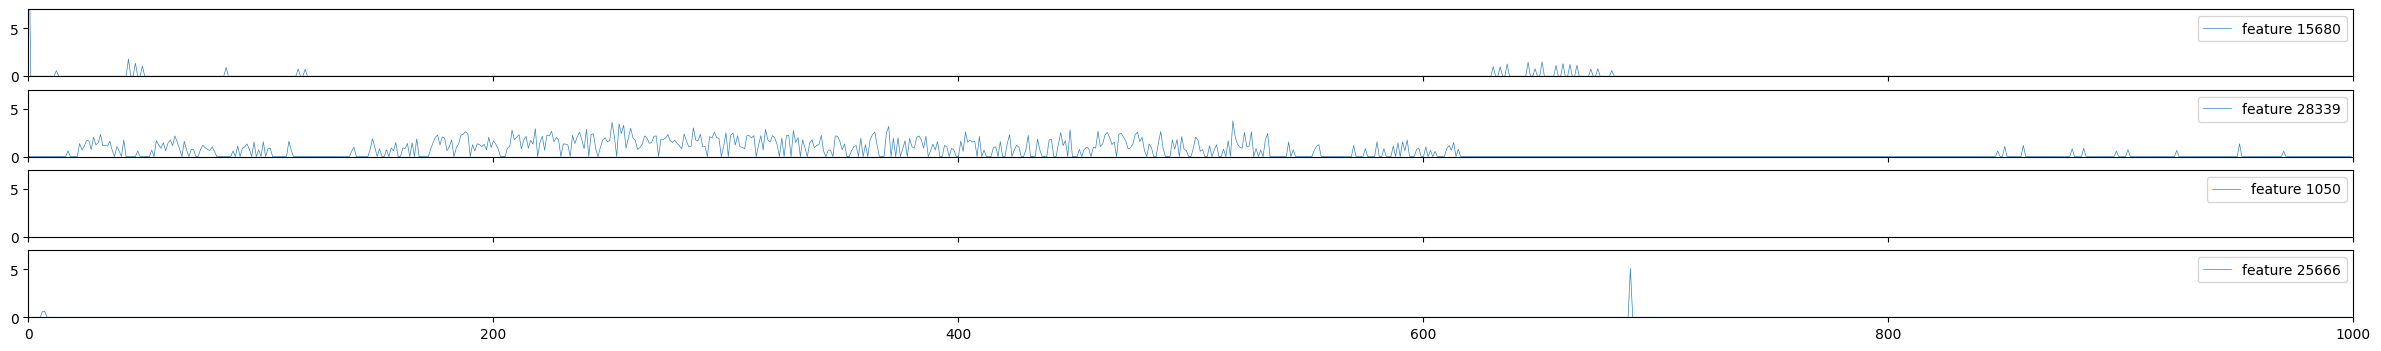

In [8]:
# Next, we plot a few of the features
selected_features = [15680, 28339, 1050, 25666]
fig, axes = plt.subplots(len(selected_features), 1, figsize = (30, 1*len(selected_features)), sharex = True)
for ind, feature in enumerate(selected_features):
    axes[ind].plot(feature_ts[:, feature], lw=0.5, label=f"feature {feature}", alpha = 0.9)
    axes[ind].set_xlim(0, feature_ts.shape[0])
    axes[ind].set_ylim([0, 7]) # just to look nice
    axes[ind].set_yticks([0, 5])
    axes[ind].legend()
plt.show()

## Demo from paper

In [9]:
def find_relevant_gb_annotations(records, window_start, window_size, 
                                valid_features={'CDS', 'gene', 'mobile_element', 'misc_feature', 
                                              'rRNA', 'tRNA', 'ncRNA', 'Regulatory', 'tmRNA'},
                                valid_qualifiers={'gene', 'locus_id', 'product', 'mobile_element_type'}):
    """
    Extract annotations from GenBank records within a specified window.
    
    Args:
        records: List of GenBank records
        window_start: Start position of window (int)
        window_size: Size of window (int)
        valid_features: Set of feature types to include
        valid_qualifiers: Set of qualifiers to extract
    
    Returns:
        List of annotations: [start, end, type, qualifiers_dict]
    """
    window_end = window_start + window_size
    annotations = []
    
    for record in records:
        for feature in record.features:
            # Skip features outside window
            if feature.location.end < window_start or feature.location.start > window_end:
                continue
                
            if feature.type in valid_features:
                # Calculate relative positions within window
                start = max(0, feature.location.start - window_start)
                end = min(window_size, feature.location.end - window_start)
                
                # Extract relevant qualifiers
                qualifiers = {q: feature.qualifiers[q] for q in valid_qualifiers 
                            if q in feature.qualifiers}
                
                annotations.append([start, end, feature.type, qualifiers])
    
    return annotations


def extract_sequence(genbank_file, start, end, strand="forward"):
    """
    Extract sequence from GenBank file at specific coordinates.
    
    Args:
        genbank_file: Path to GenBank file
        start: Start position (1-based indexing)
        end: End position (1-based indexing)
        strand: "forward" or "complement"
    
    Returns:
        Extracted sequence as string
    """
    record = SeqIO.read(genbank_file, "genbank")
    seq = record.seq[start-1:end]  # Convert to 0-based indexing
    
    if strand.lower() == "complement":
        seq = seq.reverse_complement()
        
    return str(seq)

# Annotation colors
ANNOTATION_COLORS = {
    'CDS': 'white',
    'gene': 'gray', 
    'mobile_element': 'green',
    'misc_feature': 'yellow',
    'rRNA': '#7AC8AC',
    'tRNA': '#662D91',
    'ncRNA': 'white',
    'Regulatory': 'red',
    'tmRNA': 'red'
}

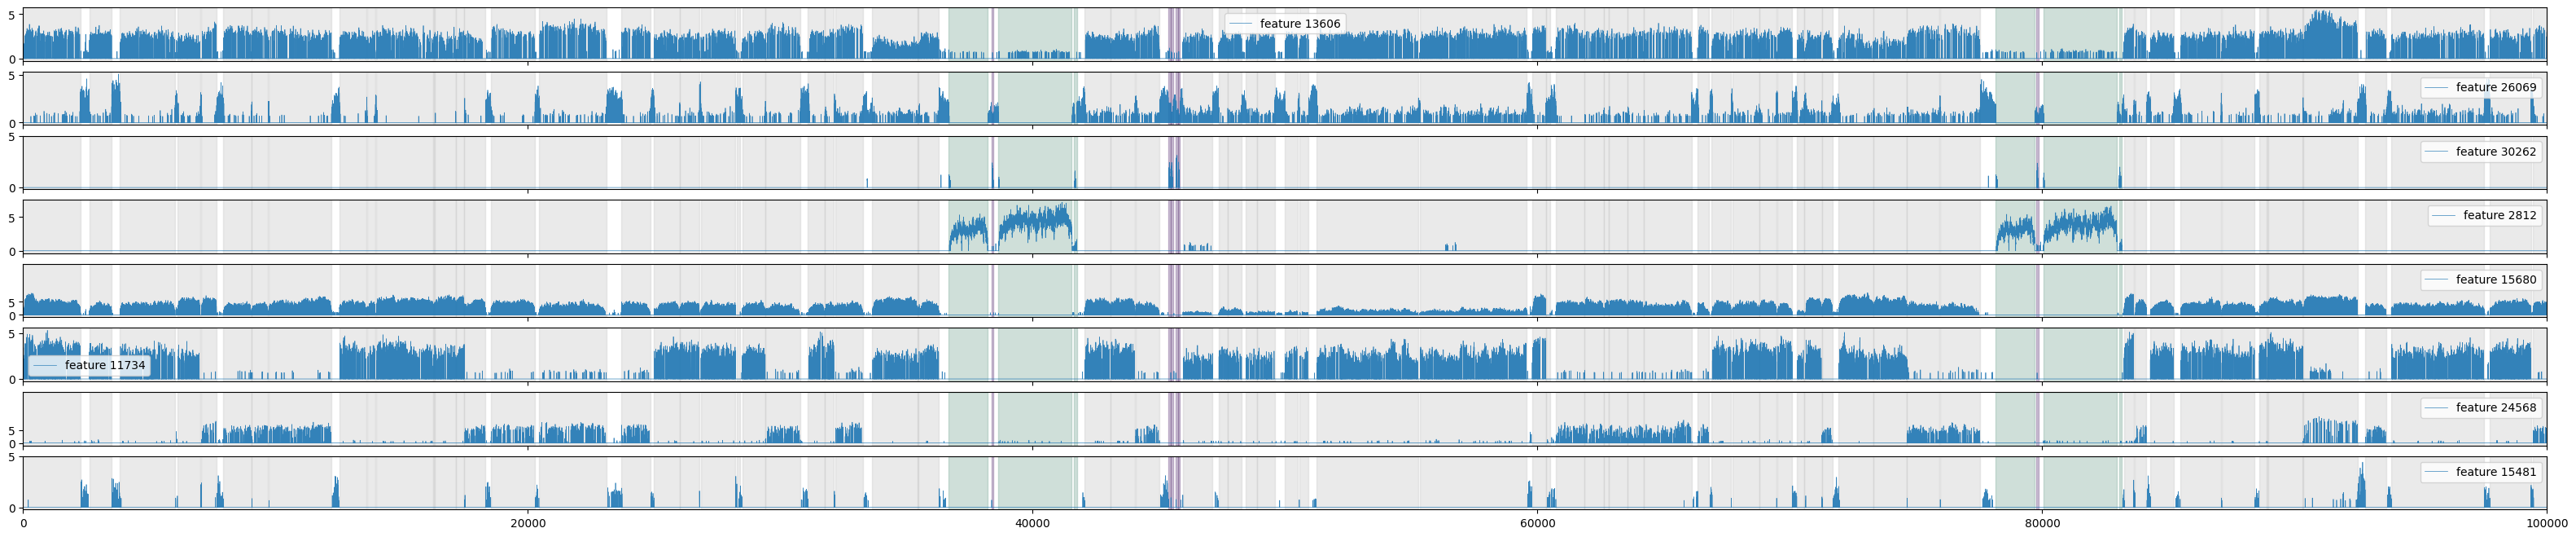

In [10]:
# Get features and plot over a 100kb chunk of the E. coli str. K-12 substr. MG1655 genome, recreating part of the main and supplementary figures
# Download from NCBI: https://www.ncbi.nlm.nih.gov/nuccore/556503834
genbank_file_path = './NC_000913.gb'
start_pos = 4130000
end_pos = 4230000
selected_features = [13606, 26069, 30262, 2812, 15680, 11734, 24568, 15481]

# Load GenBank and get features
records = list(SeqIO.parse(genbank_file_path, "genbank"))
sequence = extract_sequence(genbank_file_path, start_pos, end_pos)
annotations = find_relevant_gb_annotations(records, start_pos, end_pos - start_pos)
feature_ts = get_feature_ts(topk_sae, sequence)

# Plot selected features with genbank annotations visualized as well
fig, axes = plt.subplots(len(selected_features), 1,  figsize=(40, len(selected_features)), sharex=True)
for i, feature_id in enumerate(selected_features):
    axes[i].plot(feature_ts[:, feature_id], lw=0.5, label=f"feature {feature_id}", alpha=0.9)
    for start, end, feature_type, _ in annotations:
        axes[i].axvspan(start, end, color=ANNOTATION_COLORS.get(feature_type, 'black'), alpha=0.2)
    axes[i].set_xlim(0, feature_ts.shape[0])
    axes[i].set_yticks([0, 5])
    axes[i].legend()
plt.show()